['Gray', 'RGB', 'HSV', 'YCbCr', 'RGB_HSV', 'RGB_YCbCr', 'HSV_YCbCr', 'RGB_HSV_YCbCr']
['CASIA FASD']
['train', 'test']
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '4', '5', '6', '7', '8', '9']
['1.avi', '2.avi', '3.avi', '4.avi', '5.avi', '6.avi', '7.avi', '8.avi', 'HR_1.avi', 'HR_2.avi', 'HR_3.avi', 'HR_4.avi']
--------------------------------------------
TRAIN - [Gray]
--------------------------------------------


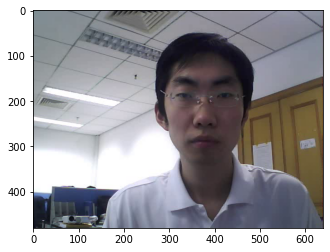

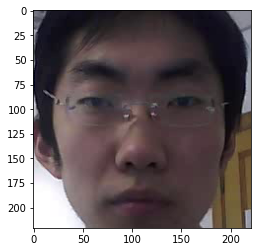

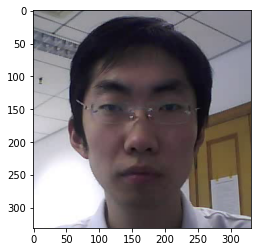

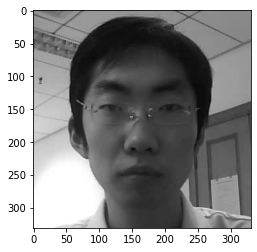

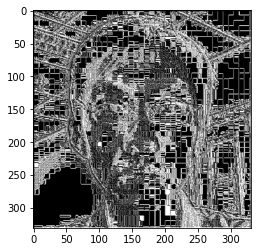

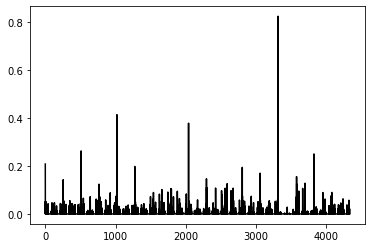

Databases/CASIA FASD/train/1/1.avi | Gray | C


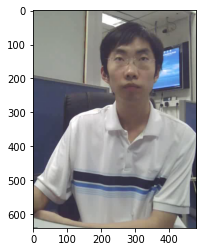

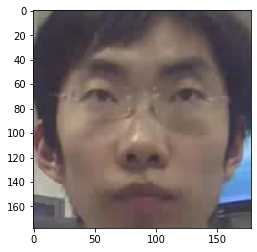

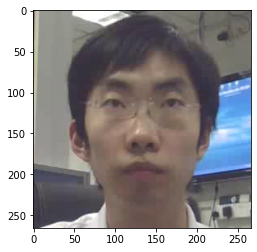

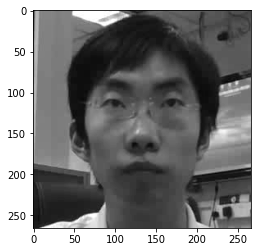

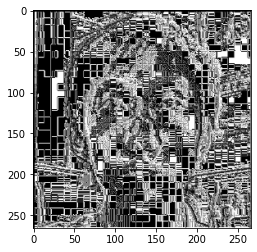

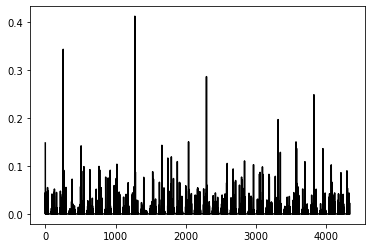

Databases/CASIA FASD/train/1/2.avi | Gray | C


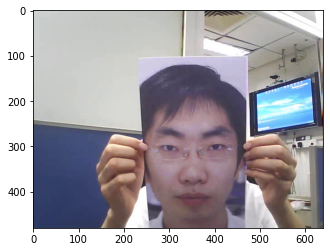

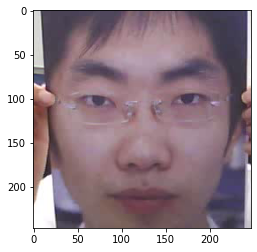

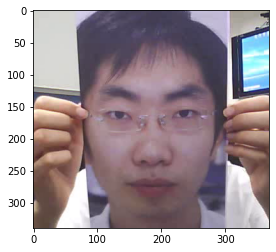

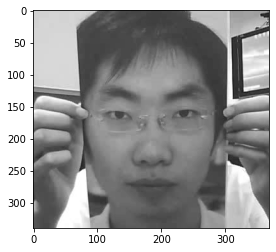

In [1]:
import cv2
import glob
import math
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.svm import SVC

P = 8
R = 1

showPlots = 1

CS = -1 # m
CN = -1 # k

colorSpace = ['Gray', 'RGB', 'HSV', 'YCbCr', 'RGB_HSV', 'RGB_YCbCr', 'HSV_YCbCr', 'RGB_HSV_YCbCr']
database = [name[10:] for name in glob.glob('Databases/*')]
dataType = ['train', 'test']
className = []
fileName = []

def main():
    #ED_LBP('A')
    #ED_LBP('B')
    ED_LBP('C')
  
def FaceDetectionAndCropping(M, figure):
    faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
    cap = cv2.VideoCapture(M)
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    i = 0
    while(totalFrames > i):
        _, a = cap.read()
        if (showPlots > 0):
            plt.figure()
            plt.imshow(cv2.cvtColor(a, cv2.COLOR_BGR2RGB))
            plt.show()
        if (figure == 'A'):
            return a
        else:
            i+= 1
            gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
            faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3)
            for (x, y, w, h) in faces:
                b = a[y:y+h, x:x+w]
            if (showPlots > 0):
                    plt.figure()
                    plt.imshow(cv2.cvtColor(b, cv2.COLOR_BGR2RGB))
                    plt.show()
            if (figure == 'B'):
                return b
            else:
                if ((y-int(h/4) > 0 and y + int(h/4) <= a.shape[0]) and (x-int(w/4) > 0 and x + int(w/4) <= a.shape[1])):
                    c = a[y-int(h/4):y+h+int(h/4), x-int(w/4):x+w+int(w/4)]
                if (showPlots > 0):
                    plt.figure()
                    plt.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
                    plt.show()
                return c

def ColorSpaceConversion(I,S):
    if S == 'Gray':
        image = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    elif S == 'RGB':
        image = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    elif S == 'HSV':
        image = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)
    elif S == 'YCbCr':
        image = cv2.cvtColor(I, cv2.COLOR_BGR2YCR_CB)
    elif S == 'RGB_HSV':
        image = np.concatenate((ColorSpaceConversion(I, 'RGB'), ColorSpaceConversion(I, 'HSV')))
    elif S == 'RGB_YCbCr':
        image = np.concatenate((ColorSpaceConversion(I, 'RGB'), ColorSpaceConversion(I, 'YCbCr')))
    elif S == 'HSV_YCbCr':
        image = np.concatenate((ColorSpaceConversion(I, 'HSV'), ColorSpaceConversion(I, 'YCbCr')))
    elif S == 'RGB_HSV_YCbCr':
        image = np.concatenate((ColorSpaceConversion(I, 'RGB'), ColorSpaceConversion(I, 'HSV'), ColorSpaceConversion(I, 'YCbCr')))
    return image

def Algorithm1(I, P):
    K = 2**P - 1
    row, col = I.shape[0], I.shape[1]
    ED_LBP = np.zeros((row, col), np.uint8)
    for x in range(2, row):
        for y in range(2, col):
            gc = I[x][y]
            gn = []
            for n in range(1, P + 1):
                gn.append(GetPixel(I, x + int(R * math.sin(2 * math.pi * n / P)), y + int(R * math.cos(2 * math.pi * n / P))))
            gnTotal = 0
            for n in range(P):
                gnTotal += gn[n]
            μ = gnTotal / (2 * P) + gc / 2
            ED_LBP[x,y] = 0
            for n in range(1, P + 1):
                if gn[n - 1] > μ:
                    A = (gn[n - 1] - μ) / (K - μ)
                    C = (P - n) * (n - 1) / math.floor(pow((P - 1) / 2, 2))
                    ED_LBP[x,y] = ED_LBP[x,y] + pow(2, (n - 1) * (1 + A * C))
    return ED_LBP

def Algorithm2(M, S, P, figure):
    I = FaceDetectionAndCropping(M, figure)
    Ii = ColorSpaceConversion(I, S)
    if (showPlots > 0):
        plt.figure()
        plt.imshow(Ii, cmap = 'gray')
        plt.show()
    l2 = 2
    if len(Ii.shape) > 2:
        L = Ii.shape[2]
    else:
        L = 1
    Ii = Ii.astype(np.uint8)
    i_min = np.min(Ii)
    i_max = np.max(Ii)
    if (i_max - i_min != 0):
        Ii = (Ii - i_min)/(i_max-i_min)
    H, W = Ii.shape[0], Ii.shape[1]
    w_step = math.floor(W/(2**l2))
    h_step = math.floor(H/(2**l2))
    if (showPlots > 0):
        colors = ['Red', 'Green', 'Blue']
    Hs = []
    for i in range(L):
        if len(Ii.shape) > 2:
            Iis = Algorithm1(Ii[:,:,i], P)
        else:
            Iis = Algorithm1(Ii, P)
        if (showPlots > 0):
            plt.figure()
            plt.imshow(Iis, cmap='gray')
            plt.show()
        Hisl0, _ = np.histogram(Iis.ravel(), bins=np.arange(0, 2**P), range=(0, 2**P))
        Hisl0 = Hisl0.astype("float")
        Hisl0 /= (Hisl0.sum() + 1e-6)
        Hisl2 = []
        y = 0
        for m in range(1, 2**l2 + 1):
            x = 0
            for n in range(1, 2**l2 + 1):
                h_m_n, _ = np.histogram(Iis[y:y+h_step, x:x+w_step].ravel(), bins=np.arange(0, 2**P), range=(0, 2**P))
                h_m_n = h_m_n.astype("float")
                h_m_n /= (h_m_n.sum() + 1e-6)
                Hisl2.append(h_m_n)
                x += w_step
            y += h_step
        His = Hisl0
        for j in range(len(Hisl2)):
            His = np.concatenate((His, Hisl2[j]))
        if (showPlots > 0):
            plt.figure()
            if len(Ii.shape) > 2:
                plt.plot(His, color = colors[i])
            else:
                plt.plot(His, color = "Black")
            plt.show()
        Hs.append(His)
    return Hs

def SVM(data, label, test, test_label, test_path, colorSpace, database, figure):
    kernels = ['linear', 'rbf']
    clf = []
    for i in range(len(kernels)):
        clf.append(SVC(kernel=kernels[i]))
    for i in range(len(clf)):
        clf[i].fit(data, label)
        true = 0
        directory = 'SVM/' + database + '/' + figure + '/' + kernels[i].capitalize()
        try:
            os.makedirs(directory, exist_ok=True)
        except FileExistsError:
            pass
        with open(directory + '/' + colorSpace + '.txt', 'w') as f:
            print('--------------------------------------------', file = f)
            print('TEST - [' + colorSpace + '] | ' + str(len(data)) + " / " + str(len(test)), file = f)
            print('--------------------------------------------', file = f)
            for n in range(len(test)):
                prediction = clf[i].predict(test[n].reshape(1, -1))
                print(' ', file = f)
                print('Path: ' + str(test_path[n]), file = f)
                print('Prediction: ' + str(prediction), file = f)
                if (prediction == test_label[n]):
                    print('State: True', file = f)
                    true += 1
                else:
                    print('State: False', file = f)
                print(' ', file = f)
                print('--------------------------------------------', file = f)
                print('n = ' + str(n+1) + ' | Total Accuracy: ' + str(true / (n+1) * 100) + " %", file = f)
                print('--------------------------------------------', file = f)

def Process(database, colorSpace, dataType, className, fileName, figure):
    for m in range(len(colorSpace)):
        if CS >= 0:
            m_state = (m == CS)
        else:
            m_state = (m != CS)
        # Color Space
        if (m_state):
            for i in range(len(database)):
                data, label, test, test_label, test_path = [], [], [], [], []
                print('--------------------------------------------')
                print('TRAIN - [' + colorSpace[m] + ']')
                print('--------------------------------------------')
                for j in range(len(dataType)):
                    for k in range(len(className)):
                        if CN >= 0:
                            k_state = (k == CN)
                        else:
                            k_state = (k != CN)
                        for l in range(len(fileName)):
                            # Path
                            M = 'Databases/' + database[i] + '/' + dataType[j] + '/' + className[k] + '/' + fileName[l]
                            if os.path.exists(M):
                                # Train
                                if (j == 0):
                                    # Class Name
                                    if (k_state):
                                        # File Name (Live)
                                        if (l == 0 or l == 1 or l == 8 or l == 11):
                                            try:
                                                live = Algorithm2(M, colorSpace[m], P, figure)
                                                for n in range(len(live)):
                                                    data.append(live[n])
                                                    label.append(1)
                                            except:
                                                continue
                                        # File Name (Spoof)
                                        else:
                                            try:
                                                spoof = Algorithm2(M, colorSpace[m], P, figure)
                                                for n in range(len(spoof)):
                                                    data.append(spoof[n])
                                                    label.append(0)
                                            except:
                                                continue
                                        print(M + ' | ' + colorSpace[m] + ' | ' + figure)
                                # Test
                                elif(j == 1):
                                    # Class Name
                                    if (k_state):
                                        try:
                                            unknow = Algorithm2(M, colorSpace[m], P, figure)
                                            for n in range(len(unknow)): 
                                                test.append(unknow[n])
                                                if len(unknow) > 1:
                                                    test_path.append(str(M) + ' | ' + str(n))
                                                else:
                                                    test_path.append(M)
                                                if (l == 0 or l == 1 or l == 8 or l == 11):
                                                    test_label.append(1)
                                                else:
                                                    test_label.append(0)
                                        except:
                                            continue
                                        print(M + ' | ' + colorSpace[m] + ' | ' + figure)
                                else:
                                    continue
                SVM(data, label, test, test_label, test_path, colorSpace[m], database[i], figure)

def ED_LBP(figure):
    Process(database, colorSpace, dataType, className, fileName, figure)

def GetPixel(I, x, y, default=0):
    try:
        return I[x][y]
    except IndexError:
        return default

if __name__ == "__main__":
    for i in range(len(database)):
        for j in range(len(dataType)):
            cN = [name[10 + len(database[i]) + 1 + len(dataType[j]) + 1:] for name in glob.glob('Databases/' + database[i] + '/' + dataType[j] + '/*')]
            for k in range(len(cN)):
                className.append(cN[k])
                className = sorted(list(set(className)))
                fN = [name[10 + len(database[i]) + 1 + len(dataType[j]) + 1 + len(className[k]) + 1:] for name in glob.glob('Databases/' + database[i] + '/' + dataType[j] + '/' + className[k] + '/*')]
                for l in range(len(fN)):
                    fileName.append(fN[l])
                    fileName = sorted(list(set(fileName)))

    print(colorSpace)
    print(database)
    print(dataType)
    print(className)
    print(fileName)

    main()